In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import json

from lora_qwen.train_lora import train_lora_model

### <p align="center"> Question 3a </p>

Training model with LoRA (default hyperparameters)...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Trainable parameters: 422,272 (0.09% of total)


Step 0:  50%|████▉     | 399/800 [2:26:26<2:24:59, 21.70s/it, loss=0.502]


Evaluating at step 400...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating model: 100%|██████████| 10/10 [02:11<00:00, 13.10s/it]


Validation metrics:
  MSE: 0.2747
  MAE: 0.3066
  R2: 0.2463
  Prey_MSE: 0.4215
  Predator_MSE: 0.1279


Step 0: 100%|█████████▉| 799/800 [4:52:14<00:22, 22.10s/it, loss=0.351]  


Evaluating at step 800...


Evaluating model: 100%|██████████| 10/10 [02:09<00:00, 12.97s/it]


Validation metrics:
  MSE: 0.2586
  MAE: 0.2892
  R2: 0.3410
  Prey_MSE: 0.4274
  Predator_MSE: 0.0898


Step 800:  50%|████▉     | 399/800 [2:25:31<2:23:03, 21.40s/it, loss=0.361]


Evaluating at step 1200...


Evaluating model: 100%|██████████| 10/10 [02:10<00:00, 13.02s/it]


Validation metrics:
  MSE: 0.2480
  MAE: 0.2764
  R2: 0.4095
  Prey_MSE: 0.4123
  Predator_MSE: 0.0837


Step 800: 100%|█████████▉| 799/800 [4:52:29<00:22, 22.10s/it, loss=0.248]  


Evaluating at step 1600...


Step 800: 100%|██████████| 800/800 [4:54:46<00:00, 22.11s/it, loss=0.248]


Validation metrics:
  MSE: 0.2551
  MAE: 0.2759
  R2: 0.4048
  Prey_MSE: 0.4172
  Predator_MSE: 0.0930


Step 1600:  50%|████▉     | 399/800 [2:42:35<2:49:23, 25.35s/it, loss=0.311]


Evaluating at step 2000...


Evaluating model: 100%|██████████| 10/10 [02:49<00:00, 16.98s/it]


Validation metrics:
  MSE: 0.0889
  MAE: 0.2018
  R2: 0.6643
  Prey_MSE: 0.1230
  Predator_MSE: 0.0547


Evaluating model: 100%|██████████| 10/10 [02:25<00:00, 14.55s/it]



Final validation metrics:
  MSE: 0.0889
  MAE: 0.2018
  R2: 0.6643
  Prey_MSE: 0.1230
  Predator_MSE: 0.0547

Comparison of Baseline vs. LoRA Fine-tuned Model:
      Metric  Baseline  LoRA Fine-tuned  Improvement (%)
         MSE    0.2747         0.088853        67.654457
         MAE    0.3066         0.201816        34.176190
          R2    0.2463         0.664345      -169.729833
    Prey_MSE    0.4215         0.123032        70.810888
Predator_MSE    0.1279         0.054674        57.252302


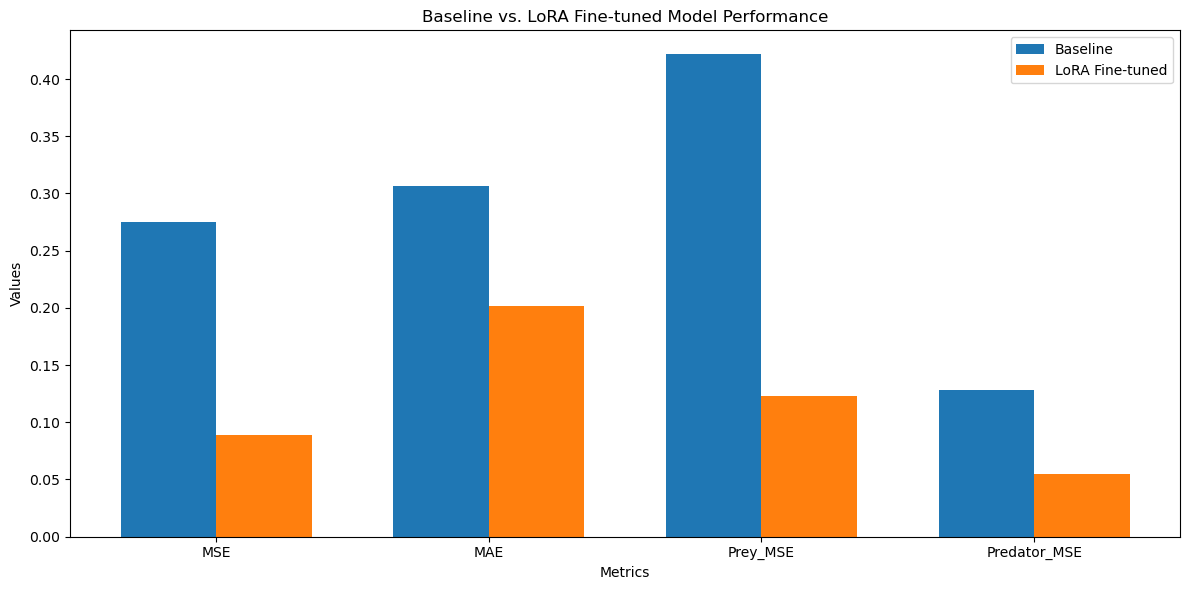

In [ ]:
parent_dir = Path().resolve().parent 
data_path = parent_dir/"data/lotka_volterra_data.h5"
results_path = parent_dir/"results/lora_results"
results_path.mkdir(exist_ok=True)

print("Training model with LoRA (default hyperparameters)...")
model, history = train_lora_model(
    data_path,
    results_path/"default_param",
    lora_rank=4,        
    learning_rate=1e-5,   
    batch_size=4,          
    max_steps=2000,         
    max_ctx_length=512,   
    eval_ctx_length=50,
    save_checkpoint_steps=400,   # 1/5 of max steps save once
    eval_steps=400,              # 1/5 of max steps evaluate once
    early_stopping_patience=2,
    #resume_from_checkpoint=results_path/"default_param"/"checkpoint_step_800.pt"
)

try:
    with open(parent_dir / "results/baseline_results/baseline_metrics.txt", "r") as f:
        baseline_content = f.read()
    
    baseline_metrics = {}
    for line in baseline_content.strip().split("\n"):
        if ":" in line:
            key, value = line.split(":", 1)
            try:
                baseline_metrics[key.strip()] = float(value.strip())
            except:
                pass
except:
    print("Baseline metrics file not found. Please run baseline evaluation first.")
    baseline_metrics = {"MSE": 0, "MAE": 0, "R2": 0, "Prey_MSE": 0, "Predator_MSE": 0}

# create comparison table
if 'final_metrics' in history:
    metrics_df = pd.DataFrame({
        'Metric': list(history['final_metrics'].keys()),
        'Baseline': [baseline_metrics.get(m, 0) for m in history['final_metrics'].keys()],
        'LoRA Fine-tuned': [history['final_metrics'][m] for m in history['final_metrics'].keys()]
    })
    
    metrics_df['Improvement (%)'] = ((metrics_df['Baseline'] - metrics_df['LoRA Fine-tuned']) / 
                                     metrics_df['Baseline'] * 100)
    
    print("\nComparison of Baseline vs. LoRA Fine-tuned Model:")
    print(metrics_df.to_string(index=False))
    
    metrics_df.to_csv(results_path / "default_param" /"baseline_vs_lora.csv", index=False)

##### visualise comarison

<Figure size 1200x600 with 0 Axes>

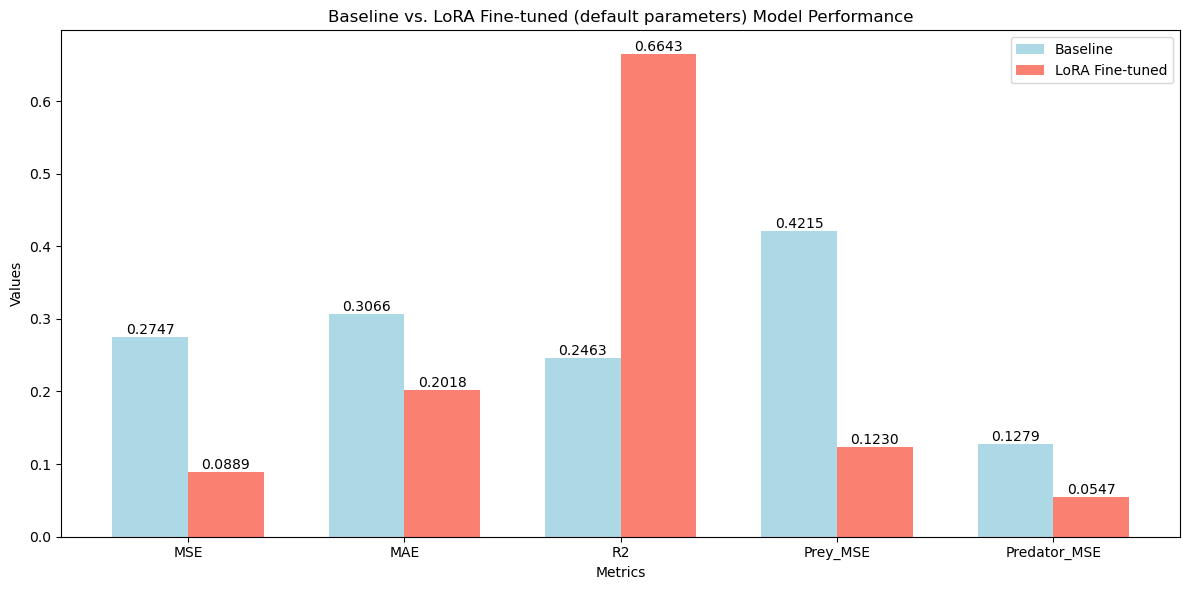

In [9]:
import pandas as pd

comparison_df = pd.read_csv(results_path / "default_param" / "baseline_vs_lora.csv")

plt.figure(figsize=(12, 6))

metrics = comparison_df['Metric'].tolist()
baseline_values = comparison_df['Baseline'].tolist()
lora_values = comparison_df['LoRA Fine-tuned'].tolist()

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='lightblue')
bars2 = ax.bar(x + width/2, lora_values, width, label='LoRA Fine-tuned', color='salmon')

# add values above the columns
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Baseline vs. LoRA Fine-tuned (default parameters) Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.savefig(results_path / "default_param" / "baseline_vs_lora.png", dpi=300)
plt.show()


### <p align="center"> Question 3b </p>

In [ ]:
parent_dir = Path().resolve().parent 
data_path = parent_dir/"data/lotka_volterra_data.h5"
results_path = parent_dir/"results/lora_results"
results_path.mkdir(exist_ok=True)

learning_rates = [1e-5, 5e-5, 1e-4]
lora_ranks = [2, 4, 8]  

results = []

# is_first_config = True

print("\nStarting hyperparameter search...")
for lr in learning_rates:
    for rank in lora_ranks:
        exp_name = f"q3b_lr_{lr}_rank_{rank}"
        print(f"\nTraining with learning_rate={lr}, lora_rank={rank}")
        
        '''# only resume from checkpoint for the first configuration
        resume_checkpoint = None
        if is_first_config:
            resume_checkpoint = results_path/"hyperparam_search"/"checkpoint_step_1200.pt"
            is_first_config = False  # Reset flag after first configuration'''
        
        config_dir = results_path/"hyperparam_search"/f"lr_{lr}_rank_{rank}"
        config_dir.mkdir(exist_ok=True, parents=True)

        model, history = train_lora_model(
            data_path,
            config_dir,
            lora_rank=rank,
            learning_rate=lr,
            batch_size=2,
            max_steps=1500, 
            max_ctx_length=320,
            eval_ctx_length=50,
            save_checkpoint_steps=300,
            eval_steps=300,
            early_stopping_patience=2, 
            #resume_from_checkpoint=resume_checkpoint
        )
        
        result = {
            'learning_rate': lr,
            'lora_rank': rank,
            'steps': len(history['training_losses']),
            'final_mse': history['final_metrics']['MSE'],
            'final_mae': history['final_metrics']['MAE'],
            'final_r2': history['final_metrics']['R2'],
            'early_stopped': len(history['training_losses']) < 1500
        }
        
        results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv(results_path / "hyperparam_search" / "hyperparameter_result.csv", index=False)

# find the best config
best_idx = results_df['final_mse'].idxmin()
best_config = {
    'learning_rate': results_df.iloc[best_idx]['learning_rate'],
    'lora_rank': int(results_df.iloc[best_idx]['lora_rank'])
}

print(f"\nBest hyperparameters: {best_config}")
print(f"Best MSE: {results_df.iloc[best_idx]['final_mse']:.4f}")


Starting hyperparameter search...

Training with learning_rate=1e-05, lora_rank=2
Trainable parameters: 287,104 (0.06% of total)
Resuming from checkpoint: D:\Cambridge\MPhil_in_DIS\term2\courseworks\M2_cw\lora_qwen\results\lora_results\hyperparam_search\checkpoint_step_1200.pt
Resuming from step 1200, previous training time: 10238.96s


Step 1200:  11%|█         | 299/2800 [39:45<4:45:41,  6.85s/it, loss=0.23] 


Evaluating at step 1500...


Step 1200:  11%|█         | 299/2800 [41:50<5:50:01,  8.40s/it, loss=0.23]


Validation metrics:
  MSE: 0.2940
  MAE: 0.3223
  R2: 0.0555
  Prey_MSE: 0.4819
  Predator_MSE: 0.1061
No improvement for 2 evaluations. Stopping early.


Evaluating model: 100%|██████████| 10/10 [02:05<00:00, 12.56s/it]



Final validation metrics:
  MSE: 0.2940
  MAE: 0.3223
  R2: 0.0555
  Prey_MSE: 0.4819
  Predator_MSE: 0.1061

Training with learning_rate=1e-05, lora_rank=4
Trainable parameters: 422,272 (0.09% of total)


Step 0:  11%|█         | 299/2800 [34:33<4:58:26,  7.16s/it, loss=0.934]


Evaluating at step 300...


Evaluating model: 100%|██████████| 10/10 [02:15<00:00, 13.50s/it]


Validation metrics:
  MSE: 0.2747
  MAE: 0.3066
  R2: 0.2463
  Prey_MSE: 0.4215
  Predator_MSE: 0.1279


Step 0:  21%|██▏       | 599/2800 [1:15:06<4:37:34,  7.57s/it, loss=0.587]


Evaluating at step 600...


Step 0:  21%|██▏       | 600/2800 [1:17:35<31:51:27, 52.13s/it, loss=0.587]

Validation metrics:
  MSE: 0.2747
  MAE: 0.3066
  R2: 0.2463
  Prey_MSE: 0.4215
  Predator_MSE: 0.1279


Step 0:  32%|███▏      | 899/2800 [1:55:34<4:01:36,  7.63s/it, loss=0.479] 


Evaluating at step 900...


Step 0:  32%|███▏      | 899/2800 [1:58:00<4:09:32,  7.88s/it, loss=0.479]


Validation metrics:
  MSE: 0.3117
  MAE: 0.3472
  R2: -0.1184
  Prey_MSE: 0.4576
  Predator_MSE: 0.1657
No improvement for 2 evaluations. Stopping early.


Evaluating model: 100%|██████████| 10/10 [02:30<00:00, 15.03s/it]



Final validation metrics:
  MSE: 0.3117
  MAE: 0.3472
  R2: -0.1184
  Prey_MSE: 0.4576
  Predator_MSE: 0.1657

Training with learning_rate=1e-05, lora_rank=8
Trainable parameters: 692,608 (0.14% of total)


Step 0:  11%|█         | 299/2800 [38:47<5:18:11,  7.63s/it, loss=0.535]


Evaluating at step 300...


Evaluating model: 100%|██████████| 10/10 [02:31<00:00, 15.17s/it]


Validation metrics:
  MSE: 0.2747
  MAE: 0.3066
  R2: 0.2463
  Prey_MSE: 0.4215
  Predator_MSE: 0.1279


Step 0:  21%|██▏       | 599/2800 [1:21:53<4:58:01,  8.12s/it, loss=0.426]


Evaluating at step 600...


Step 0:  21%|██▏       | 600/2800 [1:24:36<34:50:35, 57.02s/it, loss=0.426]

Validation metrics:
  MSE: 0.2866
  MAE: 0.3203
  R2: 0.0650
  Prey_MSE: 0.4638
  Predator_MSE: 0.1093


Step 0:  32%|███▏      | 899/2800 [2:05:13<3:51:54,  7.32s/it, loss=0.45]  


Evaluating at step 900...


Step 0:  32%|███▏      | 899/2800 [2:07:51<4:30:21,  8.53s/it, loss=0.45]


Validation metrics:
  MSE: 0.2807
  MAE: 0.3106
  R2: 0.1070
  Prey_MSE: 0.4614
  Predator_MSE: 0.1001
No improvement for 2 evaluations. Stopping early.


Evaluating model: 100%|██████████| 10/10 [02:38<00:00, 15.85s/it]



Final validation metrics:
  MSE: 0.2807
  MAE: 0.3106
  R2: 0.1070
  Prey_MSE: 0.4614
  Predator_MSE: 0.1001

Training with learning_rate=5e-05, lora_rank=2
Trainable parameters: 287,104 (0.06% of total)


Step 0:  11%|█         | 299/2800 [40:10<6:08:53,  8.85s/it, loss=0.258]


Evaluating at step 300...


Evaluating model: 100%|██████████| 10/10 [02:30<00:00, 15.09s/it]


Validation metrics:
  MSE: 0.2940
  MAE: 0.3223
  R2: 0.0555
  Prey_MSE: 0.4819
  Predator_MSE: 0.1061


Step 0:  21%|██▏       | 599/2800 [1:25:02<5:21:06,  8.75s/it, loss=0.305]


Evaluating at step 600...


Evaluating model: 100%|██████████| 10/10 [02:25<00:00, 14.56s/it]


Validation metrics:
  MSE: 0.2904
  MAE: 0.3188
  R2: 0.0746
  Prey_MSE: 0.4802
  Predator_MSE: 0.1007


Step 0:  32%|███▏      | 899/2800 [2:07:17<3:58:07,  7.52s/it, loss=0.402] 


Evaluating at step 900...


Step 0:  32%|███▏      | 900/2800 [2:09:59<29:36:29, 56.10s/it, loss=0.402]

Validation metrics:
  MSE: 0.2905
  MAE: 0.3182
  R2: 0.0961
  Prey_MSE: 0.4702
  Predator_MSE: 0.1108


Step 0:  43%|████▎     | 1199/2800 [2:47:30<3:17:02,  7.38s/it, loss=0.34]  


Evaluating at step 1200...


Evaluating model: 100%|██████████| 10/10 [02:26<00:00, 14.68s/it]


Validation metrics:
  MSE: 0.0763
  MAE: 0.1885
  R2: 0.7184
  Prey_MSE: 0.1100
  Predator_MSE: 0.0426


Step 0:  54%|█████▎    | 1499/2800 [3:27:03<2:40:35,  7.41s/it, loss=0.282] 


Evaluating at step 1500...


Step 0:  54%|█████▎    | 1499/2800 [3:29:30<3:01:50,  8.39s/it, loss=0.282]


Validation metrics:
  MSE: 0.0938
  MAE: 0.1970
  R2: 0.6187
  Prey_MSE: 0.1277
  Predator_MSE: 0.0598


Evaluating model: 100%|██████████| 10/10 [02:26<00:00, 14.64s/it]



Final validation metrics:
  MSE: 0.0938
  MAE: 0.1970
  R2: 0.6187
  Prey_MSE: 0.1277
  Predator_MSE: 0.0598

Training with learning_rate=5e-05, lora_rank=4
Trainable parameters: 422,272 (0.09% of total)


Step 0:  11%|█         | 299/2800 [37:23<5:08:07,  7.39s/it, loss=0.177]


Evaluating at step 300...


Evaluating model: 100%|██████████| 10/10 [02:24<00:00, 14.50s/it]


Validation metrics:
  MSE: 0.2842
  MAE: 0.3194
  R2: 0.0799
  Prey_MSE: 0.4530
  Predator_MSE: 0.1155


Step 0:  21%|██▏       | 599/2800 [1:17:17<4:33:54,  7.47s/it, loss=0.26] 


Evaluating at step 600...


Evaluating model: 100%|██████████| 10/10 [02:24<00:00, 14.42s/it]


Validation metrics:
  MSE: 0.2714
  MAE: 0.3084
  R2: 0.1678
  Prey_MSE: 0.4486
  Predator_MSE: 0.0942


Step 0:  32%|███▏      | 899/2800 [1:56:56<4:00:33,  7.59s/it, loss=0.34]  


Evaluating at step 900...


Evaluating model: 100%|██████████| 10/10 [02:26<00:00, 14.69s/it]


Validation metrics:
  MSE: 0.1126
  MAE: 0.2086
  R2: 0.5958
  Prey_MSE: 0.1601
  Predator_MSE: 0.0652


Step 0:  43%|████▎     | 1199/2800 [2:37:25<3:20:20,  7.51s/it, loss=0.29]  


Evaluating at step 1200...


Evaluating model: 100%|██████████| 10/10 [02:26<00:00, 14.67s/it]


Validation metrics:
  MSE: 0.0706
  MAE: 0.1802
  R2: 0.7769
  Prey_MSE: 0.0989
  Predator_MSE: 0.0422


Step 0:  54%|█████▎    | 1499/2800 [3:18:11<2:45:28,  7.63s/it, loss=0.242] 


Evaluating at step 1500...


Step 0:  54%|█████▎    | 1499/2800 [3:20:40<2:54:10,  8.03s/it, loss=0.242]


Validation metrics:
  MSE: 0.0889
  MAE: 0.1856
  R2: 0.7423
  Prey_MSE: 0.1415
  Predator_MSE: 0.0362


Evaluating model: 100%|██████████| 10/10 [02:27<00:00, 14.73s/it]



Final validation metrics:
  MSE: 0.0889
  MAE: 0.1856
  R2: 0.7423
  Prey_MSE: 0.1415
  Predator_MSE: 0.0362

Training with learning_rate=5e-05, lora_rank=8
Trainable parameters: 692,608 (0.14% of total)


Step 0:  11%|█         | 299/2800 [37:09<5:14:25,  7.54s/it, loss=0.117]


Evaluating at step 300...


Evaluating model: 100%|██████████| 10/10 [02:30<00:00, 15.02s/it]


Validation metrics:
  MSE: 0.2752
  MAE: 0.2997
  R2: 0.1877
  Prey_MSE: 0.4714
  Predator_MSE: 0.0790


Step 0:  21%|██▏       | 599/2800 [1:16:57<4:33:18,  7.45s/it, loss=0.197] 


Evaluating at step 600...


Evaluating model: 100%|██████████| 10/10 [02:26<00:00, 14.69s/it]


Validation metrics:
  MSE: 0.1499
  MAE: 0.2353
  R2: 0.5289
  Prey_MSE: 0.2286
  Predator_MSE: 0.0712


Step 0:  32%|███▏      | 899/2800 [1:56:39<3:56:55,  7.48s/it, loss=0.278] 


Evaluating at step 900...


Evaluating model: 100%|██████████| 10/10 [02:28<00:00, 14.80s/it]


Validation metrics:
  MSE: 0.0901
  MAE: 0.1799
  R2: 0.6049
  Prey_MSE: 0.1307
  Predator_MSE: 0.0496


Step 0:  43%|████▎     | 1199/2800 [2:36:16<3:21:31,  7.55s/it, loss=0.239] 


Evaluating at step 1200...


Evaluating model: 100%|██████████| 10/10 [02:30<00:00, 15.03s/it]


Validation metrics:
  MSE: 0.0505
  MAE: 0.1413
  R2: 0.7867
  Prey_MSE: 0.0674
  Predator_MSE: 0.0336


Step 0:  54%|█████▎    | 1499/2800 [3:15:36<2:38:08,  7.29s/it, loss=0.224] 


Evaluating at step 1500...


Evaluating model: 100%|██████████| 10/10 [02:24<00:00, 14.50s/it]


Validation metrics:
  MSE: 0.0444
  MAE: 0.1388
  R2: 0.8355
  Prey_MSE: 0.0526
  Predator_MSE: 0.0363


Evaluating model: 100%|██████████| 10/10 [02:25<00:00, 14.57s/it]



Final validation metrics:
  MSE: 0.0444
  MAE: 0.1388
  R2: 0.8355
  Prey_MSE: 0.0526
  Predator_MSE: 0.0363

Training with learning_rate=0.0001, lora_rank=2
Trainable parameters: 287,104 (0.06% of total)


Step 0:  11%|█         | 299/2800 [37:15<4:59:55,  7.20s/it, loss=0.143]


Evaluating at step 300...


Evaluating model: 100%|██████████| 10/10 [02:25<00:00, 14.58s/it]


Validation metrics:
  MSE: 0.2904
  MAE: 0.3188
  R2: 0.0746
  Prey_MSE: 0.4802
  Predator_MSE: 0.1007


Step 0:  21%|██▏       | 599/2800 [1:18:10<5:10:04,  8.45s/it, loss=0.223] 


Evaluating at step 600...


Evaluating model: 100%|██████████| 10/10 [02:30<00:00, 15.02s/it]


Validation metrics:
  MSE: 0.0876
  MAE: 0.1978
  R2: 0.5548
  Prey_MSE: 0.0966
  Predator_MSE: 0.0786


Step 0:  32%|███▏      | 899/2800 [2:01:17<4:51:31,  9.20s/it, loss=0.31]  


Evaluating at step 900...


Step 0:  32%|███▏      | 900/2800 [2:03:55<29:49:55, 56.52s/it, loss=0.31]

Validation metrics:
  MSE: 0.0908
  MAE: 0.1913
  R2: 0.6594
  Prey_MSE: 0.1237
  Predator_MSE: 0.0580


Step 0:  43%|████▎     | 1199/2800 [2:45:06<3:43:44,  8.39s/it, loss=0.267] 


Evaluating at step 1200...


Evaluating model: 100%|██████████| 10/10 [02:37<00:00, 15.74s/it]


Validation metrics:
  MSE: 0.0635
  MAE: 0.1585
  R2: 0.7093
  Prey_MSE: 0.0671
  Predator_MSE: 0.0599


Step 0:  54%|█████▎    | 1499/2800 [3:29:34<2:47:39,  7.73s/it, loss=0.235] 


Evaluating at step 1500...


Step 0:  54%|█████▎    | 1499/2800 [3:32:22<3:04:19,  8.50s/it, loss=0.235]


Validation metrics:
  MSE: 0.0663
  MAE: 0.1731
  R2: 0.6925
  Prey_MSE: 0.0715
  Predator_MSE: 0.0610


Evaluating model: 100%|██████████| 10/10 [02:56<00:00, 17.65s/it]



Final validation metrics:
  MSE: 0.0663
  MAE: 0.1731
  R2: 0.6925
  Prey_MSE: 0.0715
  Predator_MSE: 0.0610

Training with learning_rate=0.0001, lora_rank=4
Trainable parameters: 422,272 (0.09% of total)


Step 0:  11%|█         | 299/2800 [43:15<5:47:22,  8.33s/it, loss=0.101]


Evaluating at step 300...


Evaluating model: 100%|██████████| 10/10 [02:42<00:00, 16.25s/it]


Validation metrics:
  MSE: 0.2663
  MAE: 0.3026
  R2: 0.1876
  Prey_MSE: 0.4468
  Predator_MSE: 0.0859


Step 0:  21%|██▏       | 599/2800 [1:29:18<4:30:23,  7.37s/it, loss=0.186] 


Evaluating at step 600...


Evaluating model: 100%|██████████| 10/10 [02:55<00:00, 17.50s/it]


Validation metrics:
  MSE: 0.1113
  MAE: 0.2128
  R2: 0.6724
  Prey_MSE: 0.1810
  Predator_MSE: 0.0415


Step 0:  32%|███▏      | 899/2800 [2:15:43<5:16:02,  9.98s/it, loss=0.268] 


Evaluating at step 900...


Evaluating model: 100%|██████████| 10/10 [02:37<00:00, 15.74s/it]


Validation metrics:
  MSE: 0.0918
  MAE: 0.1778
  R2: 0.6728
  Prey_MSE: 0.1307
  Predator_MSE: 0.0528


Step 0:  43%|████▎     | 1199/2800 [3:03:19<4:52:36, 10.97s/it, loss=0.231] 


Evaluating at step 1200...


Evaluating model: 100%|██████████| 10/10 [02:43<00:00, 16.33s/it]


Validation metrics:
  MSE: 0.0384
  MAE: 0.1266
  R2: 0.8665
  Prey_MSE: 0.0448
  Predator_MSE: 0.0320


Step 0:  54%|█████▎    | 1499/2800 [3:51:44<3:05:49,  8.57s/it, loss=0.214] 


Evaluating at step 1500...


Step 0:  54%|█████▎    | 1499/2800 [3:54:50<3:23:48,  9.40s/it, loss=0.214]


Validation metrics:
  MSE: 0.0445
  MAE: 0.1403
  R2: 0.8459
  Prey_MSE: 0.0464
  Predator_MSE: 0.0427


Evaluating model: 100%|██████████| 10/10 [03:05<00:00, 18.57s/it]



Final validation metrics:
  MSE: 0.0445
  MAE: 0.1403
  R2: 0.8459
  Prey_MSE: 0.0464
  Predator_MSE: 0.0427

Training with learning_rate=0.0001, lora_rank=8
Trainable parameters: 692,608 (0.14% of total)


Step 0:  11%|█         | 299/2800 [45:29<4:58:48,  7.17s/it, loss=0.062]


Evaluating at step 300...


Evaluating model: 100%|██████████| 10/10 [02:47<00:00, 16.79s/it]


Validation metrics:
  MSE: 0.1252
  MAE: 0.2246
  R2: 0.5394
  Prey_MSE: 0.1754
  Predator_MSE: 0.0750


Step 0:  21%|██▏       | 599/2800 [1:24:51<4:19:06,  7.06s/it, loss=0.16]  


Evaluating at step 600...


Evaluating model: 100%|██████████| 10/10 [02:24<00:00, 14.44s/it]


Validation metrics:
  MSE: 0.0872
  MAE: 0.1777
  R2: 0.5909
  Prey_MSE: 0.1231
  Predator_MSE: 0.0513


Step 0:  32%|███▏      | 899/2800 [2:03:05<3:53:13,  7.36s/it, loss=0.227] 


Evaluating at step 900...


Evaluating model: 100%|██████████| 10/10 [02:13<00:00, 13.38s/it]


Validation metrics:
  MSE: 0.0420
  MAE: 0.1295
  R2: 0.8438
  Prey_MSE: 0.0519
  Predator_MSE: 0.0321


Step 0:  43%|████▎     | 1199/2800 [2:42:00<3:14:51,  7.30s/it, loss=0.214] 


Evaluating at step 1200...


Evaluating model: 100%|██████████| 10/10 [02:11<00:00, 13.16s/it]


Validation metrics:
  MSE: 0.0394
  MAE: 0.1325
  R2: 0.8310
  Prey_MSE: 0.0470
  Predator_MSE: 0.0317


Step 0:  54%|█████▎    | 1499/2800 [3:21:46<2:40:45,  7.41s/it, loss=0.204] 


Evaluating at step 1500...


Step 0:  54%|█████▎    | 1499/2800 [3:24:15<2:57:16,  8.18s/it, loss=0.204]


Validation metrics:
  MSE: 0.0514
  MAE: 0.1531
  R2: 0.8100
  Prey_MSE: 0.0594
  Predator_MSE: 0.0434


Evaluating model: 100%|██████████| 10/10 [02:19<00:00, 13.95s/it]



Final validation metrics:
  MSE: 0.0514
  MAE: 0.1531
  R2: 0.8100
  Prey_MSE: 0.0594
  Predator_MSE: 0.0434

Best hyperparameters: {'learning_rate': np.float64(5e-05), 'lora_rank': 8}
Best MSE: 0.0444



Running context length experiments...

Training with context_length=128
Trainable parameters: 692,608 (0.14% of total)


Step 0:   6%|▌         | 399/6400 [22:39<6:09:15,  3.69s/it, loss=0.285]


Evaluating at step 400...


Evaluating model: 100%|██████████| 10/10 [02:21<00:00, 14.17s/it]


Validation metrics:
  MSE: 0.2243
  MAE: 0.3285
  R2: 0.0863
  Prey_MSE: 0.3423
  Predator_MSE: 0.1064


Step 0:  12%|█▏        | 799/6400 [49:13<6:46:33,  4.36s/it, loss=0.34]  


Evaluating at step 800...


Evaluating model: 100%|██████████| 10/10 [02:25<00:00, 14.58s/it]


Validation metrics:
  MSE: 0.2102
  MAE: 0.3220
  R2: 0.0899
  Prey_MSE: 0.3341
  Predator_MSE: 0.0863


Step 0:  19%|█▊        | 1199/6400 [1:17:48<5:25:25,  3.75s/it, loss=0.22] 


Evaluating at step 1200...


Step 0:  19%|█▉        | 1200/6400 [1:20:39<80:02:30, 55.41s/it, loss=0.22]

Validation metrics:
  MSE: 0.2123
  MAE: 0.3109
  R2: 0.0685
  Prey_MSE: 0.3655
  Predator_MSE: 0.0591


Step 0:  25%|██▍       | 1599/6400 [1:47:04<4:19:54,  3.25s/it, loss=0.257] 


Evaluating at step 1600...


Step 0:  25%|██▌       | 1600/6400 [1:50:01<75:06:47, 56.33s/it, loss=0.257]

Validation metrics:
  MSE: 0.2900
  MAE: 0.3137
  R2: -0.0071
  Prey_MSE: 0.5254
  Predator_MSE: 0.0547


Step 0:  31%|███       | 1999/6400 [2:16:28<3:59:45,  3.27s/it, loss=0.166] 


Evaluating at step 2000...


Evaluating model: 100%|██████████| 10/10 [03:01<00:00, 18.11s/it]


Validation metrics:
  MSE: 0.1804
  MAE: 0.2767
  R2: 0.3193
  Prey_MSE: 0.3050
  Predator_MSE: 0.0559


Evaluating model: 100%|██████████| 10/10 [03:00<00:00, 18.01s/it]



Final validation metrics:
  MSE: 0.1804
  MAE: 0.2767
  R2: 0.3193
  Prey_MSE: 0.3050
  Predator_MSE: 0.0559

Training with context_length=512
Trainable parameters: 692,608 (0.14% of total)


Step 0:  25%|██▍       | 399/1600 [1:24:56<3:58:25, 11.91s/it, loss=0.227]


Evaluating at step 400...


Evaluating model: 100%|██████████| 10/10 [02:16<00:00, 13.69s/it]


Validation metrics:
  MSE: 0.0725
  MAE: 0.1718
  R2: 0.7425
  Prey_MSE: 0.1092
  Predator_MSE: 0.0358


Step 0:  50%|████▉     | 799/1600 [2:42:24<2:31:08, 11.32s/it, loss=0.123] 


Evaluating at step 800...


Evaluating model: 100%|██████████| 10/10 [02:11<00:00, 13.12s/it]


Validation metrics:
  MSE: 0.0332
  MAE: 0.1167
  R2: 0.8544
  Prey_MSE: 0.0340
  Predator_MSE: 0.0323


Step 0:  75%|███████▍  | 1199/1600 [3:58:48<1:15:15, 11.26s/it, loss=0.168] 


Evaluating at step 1200...


Step 0:  75%|███████▌  | 1200/1600 [4:01:02<5:41:18, 51.20s/it, loss=0.168]

Validation metrics:
  MSE: 0.0403
  MAE: 0.1274
  R2: 0.8319
  Prey_MSE: 0.0547
  Predator_MSE: 0.0258


Step 0: 100%|█████████▉| 1599/1600 [5:14:39<00:11, 11.11s/it, loss=0.162]   


Evaluating at step 1600...


Evaluating model: 100%|██████████| 10/10 [02:07<00:00, 12.72s/it]


Validation metrics:
  MSE: 0.0272
  MAE: 0.0989
  R2: 0.8792
  Prey_MSE: 0.0221
  Predator_MSE: 0.0323


Step 1600:  25%|██▍       | 399/1600 [1:13:39<3:37:09, 10.85s/it, loss=0.108] 


Evaluating at step 2000...


Evaluating model: 100%|██████████| 10/10 [02:06<00:00, 12.68s/it]


Validation metrics:
  MSE: 0.0232
  MAE: 0.0880
  R2: 0.9063
  Prey_MSE: 0.0141
  Predator_MSE: 0.0322


Evaluating model: 100%|██████████| 10/10 [02:08<00:00, 12.88s/it]



Final validation metrics:
  MSE: 0.0232
  MAE: 0.0880
  R2: 0.9063
  Prey_MSE: 0.0141
  Predator_MSE: 0.0322

Training with context_length=768
Trainable parameters: 692,608 (0.14% of total)


Step 0:  33%|███▎      | 399/1200 [1:52:48<3:42:22, 16.66s/it, loss=0.208] 


Evaluating at step 400...


Evaluating model: 100%|██████████| 10/10 [02:09<00:00, 12.93s/it]


Validation metrics:
  MSE: 0.2748
  MAE: 0.2993
  R2: 0.1507
  Prey_MSE: 0.4606
  Predator_MSE: 0.0891


Step 0:  67%|██████▋   | 799/1200 [3:47:15<1:51:28, 16.68s/it, loss=0.11]  


Evaluating at step 800...


Evaluating model: 100%|██████████| 10/10 [02:14<00:00, 13.42s/it]


Validation metrics:
  MSE: 0.0880
  MAE: 0.1770
  R2: 0.7253
  Prey_MSE: 0.1416
  Predator_MSE: 0.0343


Step 0: 100%|█████████▉| 1199/1200 [5:49:50<00:18, 18.42s/it, loss=0.162]  


Evaluating at step 1200...


Evaluating model: 100%|██████████| 10/10 [02:57<00:00, 17.72s/it]


Validation metrics:
  MSE: 0.0470
  MAE: 0.1348
  R2: 0.8056
  Prey_MSE: 0.0610
  Predator_MSE: 0.0331


Step 1200:  33%|███▎      | 399/1200 [2:13:33<4:11:22, 18.83s/it, loss=0.117] 


Evaluating at step 1600...


Evaluating model: 100%|██████████| 10/10 [03:05<00:00, 18.53s/it]


Validation metrics:
  MSE: 0.0355
  MAE: 0.1165
  R2: 0.8650
  Prey_MSE: 0.0394
  Predator_MSE: 0.0316


Step 1200:  67%|██████▋   | 799/1200 [4:26:28<1:58:04, 17.67s/it, loss=0.0574]


Evaluating at step 2000...


Evaluating model: 100%|██████████| 10/10 [02:24<00:00, 14.41s/it]


Validation metrics:
  MSE: 0.0312
  MAE: 0.1084
  R2: 0.8648
  Prey_MSE: 0.0312
  Predator_MSE: 0.0313


Evaluating model: 100%|██████████| 10/10 [02:25<00:00, 14.52s/it]



Final validation metrics:
  MSE: 0.0312
  MAE: 0.1084
  R2: 0.8648
  Prey_MSE: 0.0312
  Predator_MSE: 0.0313

Best context length: 512
Best MSE: 0.0232


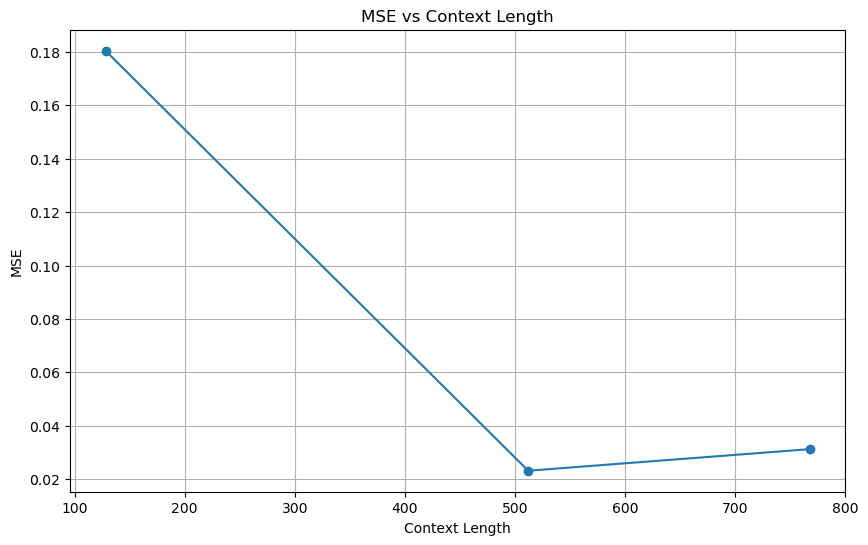

In [ ]:
parent_dir = Path().resolve().parent 
data_path = parent_dir/"data/lotka_volterra_data.h5"
results_path = parent_dir/"results/lora_results"
results_path.mkdir(exist_ok=True)

context_lengths = [128, 512, 768]
context_results = []

print("\nRunning context length experiments...")
for ctx_len in context_lengths:
    exp_name = f"q3b_ctx_{ctx_len}"
    print(f"\nTraining with context_length={ctx_len}")
    
    model, history = train_lora_model(
        data_path,
        results_path/"ctx_length_search",
        lora_rank=best_config['lora_rank'],
        learning_rate=best_config['learning_rate'],
        batch_size=2,
        max_steps=2000, 
        max_ctx_length=ctx_len,
        eval_ctx_length=50,
        save_checkpoint_steps=400,
        eval_steps=400,  
        early_stopping_patience=3,
    )
    
    result = {
        'context_length': ctx_len,
        'steps': len(history['training_losses']),
        'final_mse': history['final_metrics']['MSE'],
        'final_mae': history['final_metrics']['MAE'],
        'final_r2': history['final_metrics']['R2'],
        'early_stopped': len(history['training_losses']) < 2000
    }
    
    context_results.append(result)

context_df = pd.DataFrame(context_results)
context_df.to_csv(results_path / "ctx_length_search"/ "context_length.csv", index=False)

best_ctx_idx = context_df['final_mse'].idxmin()
best_ctx_length = int(context_df.iloc[best_ctx_idx]['context_length'])

print(f"\nBest context length: {best_ctx_length}")
print(f"Best MSE: {context_df.iloc[best_ctx_idx]['final_mse']:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(context_df['context_length'], context_df['final_mse'], 'o-')
plt.title('MSE vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('MSE')
plt.grid(True)
plt.savefig(results_path / "ctx_length_search" / "context_effect.png", dpi=300)
plt.show()

with open(results_path / "ctx_length_search" / "best_config.json", "w") as f:
    json.dump({
        'learning_rate': best_config['learning_rate'],
        'lora_rank': best_config['lora_rank'],
        'context_length': best_ctx_length
    }, f, indent=4)

### <p align="center"> Question 3c </p>

In [3]:
parent_dir = Path().resolve().parent 
data_path = parent_dir/"data/lotka_volterra_data.h5"
results_path = parent_dir/"results/lora_results"
results_path.mkdir(exist_ok=True)

# load the best config
with open(results_path / "ctx_length_search" / "best_config.json", "r") as f:
    best_config = json.load(f)

print("\nTraining final model with best hyperparameters:")
print(f"- Learning rate: {best_config['learning_rate']}")
print(f"- LoRA rank: {best_config['lora_rank']}")
print(f"- Context length: {best_config['context_length']}")

final_model, final_history = train_lora_model(
    data_path,
    results_path/"final_model",
    lora_rank=best_config['lora_rank'],
    learning_rate=best_config['learning_rate'],
    batch_size=4,
    max_steps=15000,
    max_ctx_length=best_config['context_length'],
    eval_ctx_length=50,
    save_checkpoint_steps=100,
    eval_steps=100,
    early_stopping_patience=3,
    resume_from_checkpoint=results_path/"final_model"/"checkpoint_step_9000.pt"
)

try:
    with open(parent_dir / "results/baseline_results/baseline_metrics.txt", "r") as f:
        baseline_content = f.read()
    
    baseline_metrics = {}
    for line in baseline_content.strip().split("\n"):
        if ":" in line:
            key, value = line.split(":", 1)
            try:
                baseline_metrics[key.strip()] = float(value.strip())
            except:
                pass
    
    # create comparison table
    metrics = ['MSE', 'MAE', 'R2', 'Prey_MSE', 'Predator_MSE']
    baseline_values = [baseline_metrics.get(m, 0) for m in metrics]
    final_values = [final_history['final_metrics'].get(m, 0) for m in metrics]
    
    improvements = []
    for m, b, f in zip(metrics, baseline_values, final_values):
        imp_pct = (b - f) / b * 100 if b != 0 else 0
        improvements.append({
            'Metric': m,
            'Baseline': b,
            'Final Model': f,
            'Improvement (%)': imp_pct
        })
    
    final_comparison = pd.DataFrame(improvements)
    print("\nPerformance comparison:")
    print(final_comparison.to_string(index=False))
    
    final_comparison.to_csv(results_path / "final_model" / "final_comparison.csv", index=False)
    
except Exception as e:
    print(f"Error comparing with baseline: {e}")



Training final model with best hyperparameters:
- Learning rate: 5e-05
- LoRA rank: 8
- Context length: 512


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Trainable parameters: 692,608 (0.14% of total)
Resuming from checkpoint: D:\Cambridge\MPhil_in_DIS\term2\courseworks\M2_cw\lora_qwen\results\lora_results\final_model\checkpoint_step_9000.pt
Resuming from step 9000, previous training time: 236235.26s


Step 9000:  12%|█▏        | 99/800 [59:27<6:25:35, 33.00s/it, loss=0.0787]


Evaluating at step 9100...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating model: 100%|██████████| 10/10 [03:40<00:00, 22.01s/it]


Validation metrics:
  MSE: 0.0182
  MAE: 0.0756
  R2: 0.7995
  Prey_MSE: 0.0155
  Predator_MSE: 0.0210


Step 9000:  25%|██▍       | 199/800 [1:58:55<5:27:19, 32.68s/it, loss=0.111]   


Evaluating at step 9200...


Step 9000:  25%|██▌       | 200/800 [2:02:19<15:13:04, 91.31s/it, loss=0.111]

Validation metrics:
  MSE: 0.0241
  MAE: 0.0858
  R2: 0.9636
  Prey_MSE: 0.0230
  Predator_MSE: 0.0252


Step 9000:  37%|███▋      | 299/800 [2:54:11<4:15:18, 30.58s/it, loss=0.107]  


Evaluating at step 9300...


Evaluating model: 100%|██████████| 10/10 [03:17<00:00, 19.75s/it]


Validation metrics:
  MSE: 0.0167
  MAE: 0.0636
  R2: 0.4744
  Prey_MSE: 0.0061
  Predator_MSE: 0.0272


Step 9000:  50%|████▉     | 399/800 [3:47:21<3:05:13, 27.71s/it, loss=0.0833] 


Evaluating at step 9400...


Evaluating model: 100%|██████████| 10/10 [02:52<00:00, 17.26s/it]


Validation metrics:
  MSE: 0.0141
  MAE: 0.0633
  R2: 0.9700
  Prey_MSE: 0.0079
  Predator_MSE: 0.0203


Step 9000:  62%|██████▏   | 499/800 [4:39:23<2:22:51, 28.48s/it, loss=0.0969]


Evaluating at step 9500...


Step 9000:  62%|██████▎   | 500/800 [4:42:16<7:00:27, 84.09s/it, loss=0.0969]

Validation metrics:
  MSE: 0.0191
  MAE: 0.0726
  R2: 0.9641
  Prey_MSE: 0.0144
  Predator_MSE: 0.0238


Step 9000:  75%|███████▍  | 599/800 [5:29:29<1:31:23, 27.28s/it, loss=0.112] 


Evaluating at step 9600...


Step 9000:  75%|███████▌  | 600/800 [5:32:35<4:32:33, 81.77s/it, loss=0.112]

Validation metrics:
  MSE: 0.0240
  MAE: 0.0811
  R2: 0.9568
  Prey_MSE: 0.0137
  Predator_MSE: 0.0343


Step 9000:  87%|████████▋ | 699/800 [6:18:29<42:01, 24.96s/it, loss=0.0919]  


Evaluating at step 9700...


Step 9000:  87%|████████▋ | 699/800 [6:21:29<55:07, 32.75s/it, loss=0.0919]


Validation metrics:
  MSE: 0.0166
  MAE: 0.0762
  R2: 0.8803
  Prey_MSE: 0.0111
  Predator_MSE: 0.0221
No improvement for 3 evaluations. Stopping early.


Evaluating model: 100%|██████████| 10/10 [03:00<00:00, 18.07s/it]



Final validation metrics:
  MSE: 0.0169
  MAE: 0.0663
  R2: 0.9310
  Prey_MSE: 0.0057
  Predator_MSE: 0.0281

Performance comparison:
      Metric  Baseline  Final Model  Improvement (%)
         MSE    0.2747     0.016898        93.848391
         MAE    0.3066     0.066283        78.381189
          R2    0.2463     0.931019      -278.002026
    Prey_MSE    0.4215     0.005693        98.649246
Predator_MSE    0.1279     0.028104        78.026965


##### visualise comarison

<Figure size 1200x600 with 0 Axes>

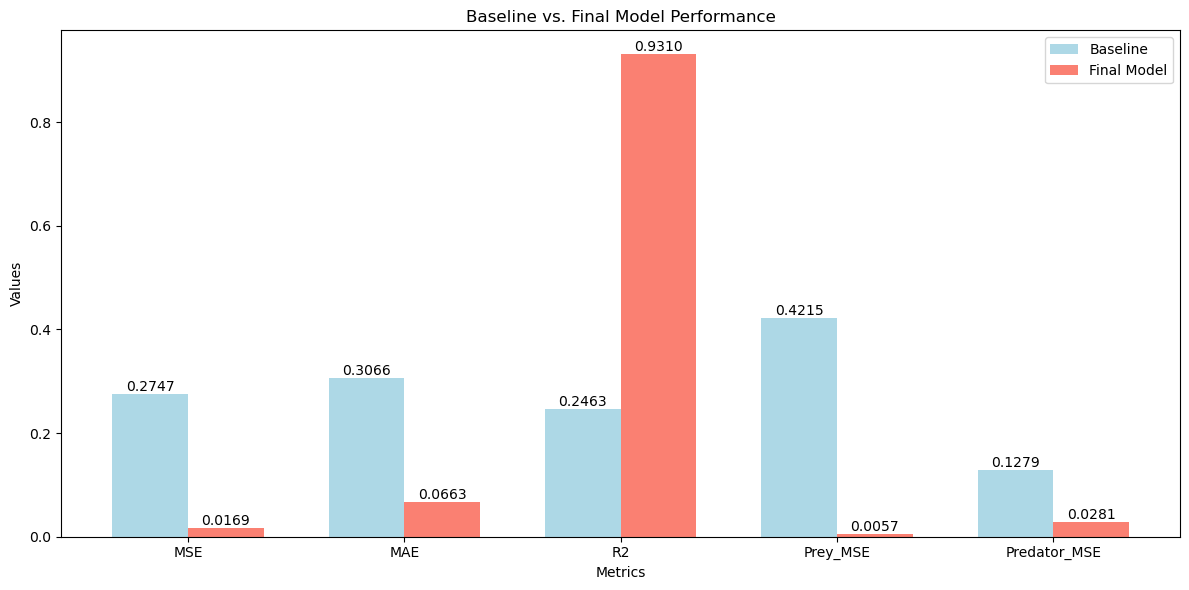

In [5]:
import pandas as pd
from pathlib import Path

parent_dir = Path().resolve().parent 
data_path = parent_dir/"data/lotka_volterra_data.h5"
results_path = parent_dir/"results/lora_results"
results_path.mkdir(exist_ok=True)

comparison_df = pd.read_csv(results_path / "final_model" /  "final_comparison.csv")

plt.figure(figsize=(12, 6))

metrics = comparison_df['Metric'].tolist()
baseline_values = comparison_df['Baseline'].tolist()
lora_values = comparison_df['Final Model'].tolist()

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='lightblue')
bars2 = ax.bar(x + width/2, lora_values, width, label='Final Model', color='salmon')

# add values above the columns
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Baseline vs. Final Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.savefig(results_path / "final_model" / "final_comparison.png", dpi=300)
plt.show()
